Enter your age:  21
Enter your height (in meters):  1.59
Enter your weight (in kg):  56


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Predicted BMI: 22.16
Calculated BMI (based on height and weight): 22.15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Predicted BMIcase: Normal weight
Nutrition Recommendation: Maintain a balanced diet with adequate nutrients.
Exercise Recommendation: Continue regular exercise, mixing cardio and strength training.
Test Accuracy for Exercise Recommendation Plan model: 82.75%
Test MAE for BMI prediction model: 0.02
Test Accuracy for BMIcase model: 94.90%


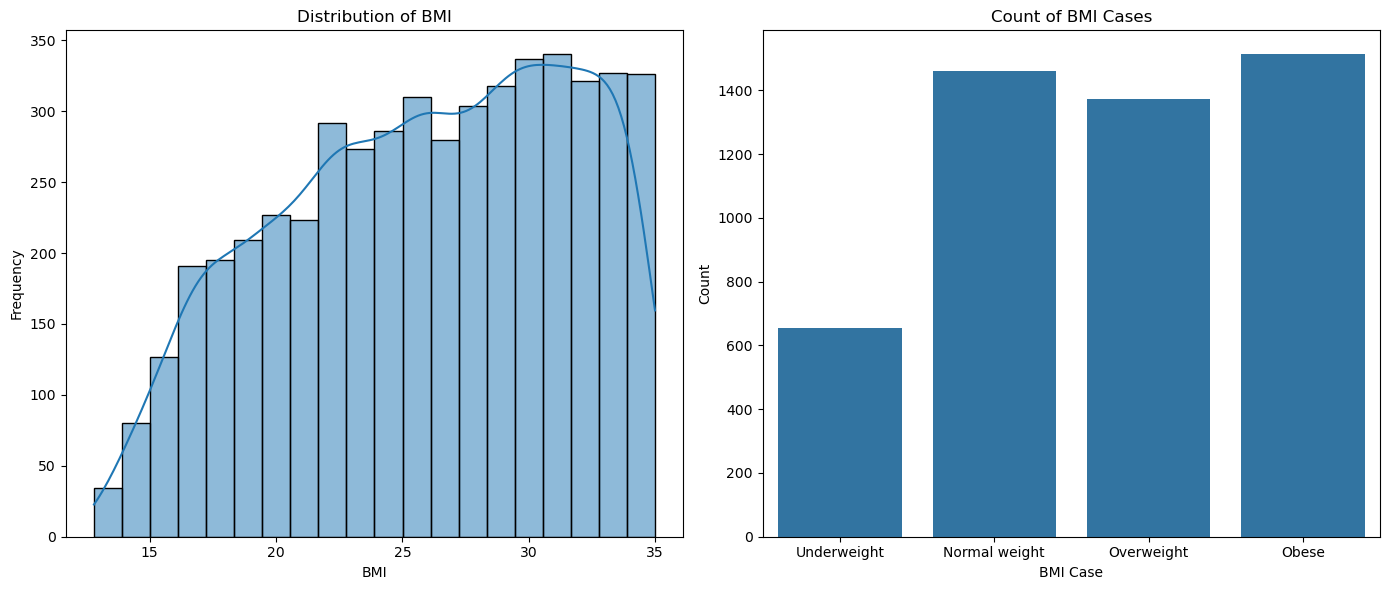

C:\Users\compu market\AppData\Local\Temp\ipykernel_13744\3974426039.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


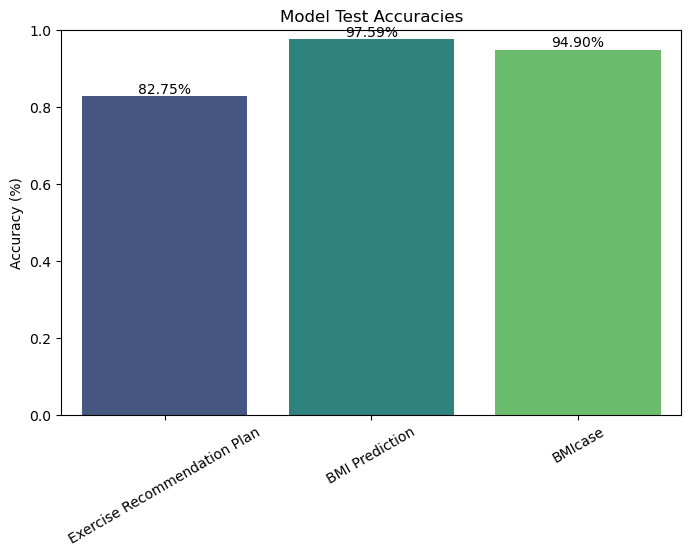

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import load_model

data = pd.read_csv('final_dataset.csv')
data = data.apply(pd.to_numeric, errors='coerce')

le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])
data.dropna(subset=['Age', 'Height', 'Weight', 'BMI', 'Exercise Recommendation Plan'], inplace=True)

bins = [-np.inf, 18.5, 24.9, 29.9, np.inf]
labels = ['Underweight', 'Normal weight', 'Overweight', 'Obese']
data['BMIcase'] = pd.cut(data['BMI'], bins=bins, labels=labels)

X = data[['Age', 'Height', 'Weight', 'Gender']].values  
y_bmi = data['BMI'].values  
y_exercise_plan = data['Exercise Recommendation Plan'].values
y_bmicas = data['BMIcase'].values

scaler_X = StandardScaler()   
X_scaled = scaler_X.fit_transform(X)

scaler_bmi = StandardScaler()
y_bmi_scaled = scaler_bmi.fit_transform(y_bmi.reshape(-1, 1)).flatten()

label_encoder_exercise_plan = OneHotEncoder(sparse_output=False)
y_exercise_plan_encoded = label_encoder_exercise_plan.fit_transform(y_exercise_plan.reshape(-1, 1))

label_encoder_bmicas = OneHotEncoder(sparse_output=False)
y_bmicas_encoded = label_encoder_bmicas.fit_transform(y_bmicas.reshape(-1, 1))

X_train, X_test, y_train_bmi, y_test_bmi = train_test_split(X_scaled, y_bmi_scaled, test_size=0.2, random_state=42)
X_train_plan, X_test_plan, y_train_plan, y_test_plan = train_test_split(X_scaled, y_exercise_plan_encoded, test_size=0.4, random_state=42)
X_train_bmicas, X_test_bmicas, y_train_bmicas, y_test_bmicas = train_test_split(X_scaled, y_bmicas_encoded, test_size=0.4, random_state=42)

X_train_rnn = np.expand_dims(X_train, axis=1)
X_test_rnn = np.expand_dims(X_test, axis=1)
X_train_plan_rnn = np.expand_dims(X_train_plan, axis=1)
X_test_plan_rnn = np.expand_dims(X_test_plan, axis=1)
X_train_bmicas_rnn = np.expand_dims(X_train_bmicas, axis=1)
X_test_bmicas_rnn = np.expand_dims(X_test_bmicas, axis=1)

model_exercise_plan = load_model('model_exercise_plan.keras')
model_bmi = load_model('model_bmi.keras')
model_bmicas = load_model('model_bmicas.keras')

def get_nutrition_and_exercise_recommendations(bmi_case):
    recommendations = {
        'nutrition': '',
        'exercise': ''
    }
    if bmi_case == 'Underweight':
        recommendations['nutrition'] = 'Increase caloric intake with nutritious foods.'
        recommendations['exercise'] = 'Focus on strength training to build muscle mass.'
    elif bmi_case == 'Normal weight':
        recommendations['nutrition'] = 'Maintain a balanced diet with adequate nutrients.'
        recommendations['exercise'] = 'Continue regular exercise, mixing cardio and strength training.'
    elif bmi_case == 'Overweight':
        recommendations['nutrition'] = 'Reduce caloric intake and focus on healthy foods.'
        recommendations['exercise'] = 'Incorporate regular cardio exercises and strength training.'
    elif bmi_case == 'Obese':
        recommendations['nutrition'] = 'Consult a nutritionist for a tailored meal plan.'
        recommendations['exercise'] = 'Start with low-impact exercises and gradually increase intensity.'
    return recommendations

def predict_user_data():
    age = float(input("Enter your age: "))
    height = float(input("Enter your height (in meters): "))
    weight = float(input("Enter your weight (in kg): "))
    
    user_data = np.array([[age, height, weight, 0]])  
    user_data_scaled = scaler_X.transform(user_data)
    user_data_rnn = np.expand_dims(user_data_scaled, axis=1)

    bmi_prediction = model_bmi.predict(user_data_rnn)
    bmi_prediction_rescaled = scaler_bmi.inverse_transform(bmi_prediction)[0][0]
    print(f"Predicted BMI: {bmi_prediction_rescaled:.2f}")
    
    calculated_bmi = weight / (height ** 2)
    print(f"Calculated BMI (based on height and weight): {calculated_bmi:.2f}")

    bmicas_prediction = model_bmicas.predict(user_data_rnn)
    predicted_bmicas = label_encoder_bmicas.inverse_transform(bmicas_prediction)

    recommendations = get_nutrition_and_exercise_recommendations(predicted_bmicas[0][0])
    print(f"Predicted BMIcase: {predicted_bmicas[0][0]}")
    print("Nutrition Recommendation:", recommendations['nutrition'])
    print("Exercise Recommendation:", recommendations['exercise'])

predict_user_data()

_, accuracy_exercise_plan = model_exercise_plan.evaluate(X_test_plan_rnn, y_test_plan, verbose=0)
_, mae_bmi = model_bmi.evaluate(X_test_rnn, y_test_bmi, verbose=0)
_, accuracy_bmicas = model_bmicas.evaluate(X_test_bmicas_rnn, y_test_bmicas, verbose=0)

print(f"Test Accuracy for Exercise Recommendation Plan model: {accuracy_exercise_plan * 100:.2f}%")
print(f"Test MAE for BMI prediction model: {mae_bmi:.2f}")
print(f"Test Accuracy for BMIcase model: {accuracy_bmicas * 100:.2f}%")

def plot_summary(data):
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data['BMI'], bins=20, kde=True)
    plt.title('Distribution of BMI')
    plt.xlabel('BMI')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.countplot(x=data['BMIcase'])
    plt.title('Count of BMI Cases')
    plt.xlabel('BMI Case')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

plot_summary(data)

def plot_accuracy(accuracies):
    models = ['Exercise Recommendation Plan', 'BMI Prediction', 'BMIcase']
    plt.figure(figsize=(8, 5))
    sns.barplot(x=models, y=accuracies, palette='viridis')
    plt.title('Model Test Accuracies')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 1) 
    plt.xticks(rotation=30)
    for index, value in enumerate(accuracies):
        plt.text(index, value, f'{value * 100:.2f}%', ha='center', va='bottom')
    plt.show()

plot_accuracy([accuracy_exercise_plan, 1 - mae_bmi, accuracy_bmicas]) 